In [1]:
try:
    import tinygp
except ImportError:
    %pip install -q tinygp

try:
    import flax
except ImportError:
    %pip install -q flax

try:
    import optax
except ImportError:
    %pip install -q optax

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans


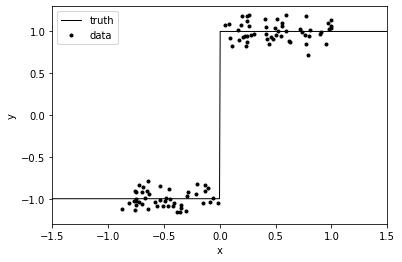

In [2]:
import numpy as np
import matplotlib.pyplot as plt

random = np.random.default_rng(567)

noise = 0.1

x = np.sort(random.uniform(-1, 1, 100))
y = 2 * (x > 0) - 1 + random.normal(0.0, noise, len(x))
t = np.linspace(-1.5, 1.5, 500)

plt.plot(t, 2 * (t > 0) - 1, "k", lw=1, label="truth")
plt.plot(x, y, ".k", label="data")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.3, 1.3)
plt.xlabel("x")
plt.ylabel("y")
_ = plt.legend()

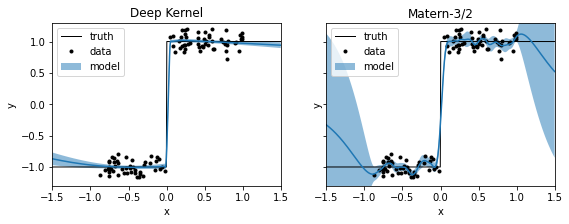

In [40]:
import jax
import optax
import jax.numpy as jnp
import flax.linen as nn
from flax.linen.initializers import zeros
from tinygp import kernels, transforms, GaussianProcess


class Matern_Kernel_GPLoss(nn.Module):
    @nn.compact
    def __call__(self, x, y, t):
        # Set up a typical Matern-3/2 kernel
        log_sigma = self.param("log_sigma", zeros, ())
        log_rho = self.param("log_rho", zeros, ())
        log_jitter = self.param("log_jitter", zeros, ())
        base_kernel = jnp.exp(2 * log_sigma) * kernels.Matern32(jnp.exp(log_rho))

        # Evaluate and return the GP negative log likelihood as usual
        gp = GaussianProcess(
            base_kernel, x[:, None], diag=noise ** 2 + jnp.exp(2 * log_jitter)
        )
        log_prob, gp_cond = gp.condition(y, t[:, None])
        return -log_prob, (gp_cond.loc, gp_cond.variance)


# Define a small neural network used to non-linearly transform the input data in our model
class Transformer(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=15)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return x


class Deep_Kernel_GPLoss(nn.Module):
    @nn.compact
    def __call__(self, x, y, t):
        # Set up a typical Matern-3/2 kernel
        log_sigma = self.param("log_sigma", zeros, ())
        log_rho = self.param("log_rho", zeros, ())
        log_jitter = self.param("log_jitter", zeros, ())
        base_kernel = jnp.exp(2 * log_sigma) * kernels.Matern32(jnp.exp(log_rho))

        # Define a custom transform to pass the input coordinates through our `Transformer`
        # network from above
        transform = Transformer()
        kernel = transforms.Transform(transform, base_kernel)

        # Evaluate and return the GP negative log likelihood as usual
        gp = GaussianProcess(
            kernel, x[:, None], diag=noise ** 2 + jnp.exp(2 * log_jitter)
        )
        log_prob, gp_cond = gp.condition(y, t[:, None])
        return -log_prob, (gp_cond.loc, gp_cond.variance), transform


def loss_func(model):
    def loss(params):
        return model.apply(params, x, y, t)[0]

    return loss

models_list = []
params_list = []
# Plot the results and compare to the true model
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(9, 3))
for it, (model_name, model) in enumerate(
    zip(["Deep Kernel", "Matern-3/2"], [Deep_Kernel_GPLoss(), Matern_Kernel_GPLoss()])
):
    params = model.init(jax.random.PRNGKey(1234), x, y, t)
    tx = optax.sgd(learning_rate=1e-4)
    opt_state = tx.init(params)

    loss = loss_func(model)
    loss_grad_fn = jax.jit(jax.value_and_grad(loss))
    for i in range(1000):
        loss_val, grads = loss_grad_fn(params)
        updates, opt_state = tx.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

    mu, var = model.apply(params, x, y, t)[1]
    ax[it].plot(t, 2 * (t > 0) - 1, "k", lw=1, label="truth")
    ax[it].plot(x, y, ".k", label="data")
    ax[it].plot(t, mu)
    ax[it].fill_between(
        t, mu + np.sqrt(var), mu - np.sqrt(var), alpha=0.5, label="model"
    )
    ax[it].set_xlim(-1.5, 1.5)
    ax[it].set_ylim(-1.3, 1.3)
    ax[it].set_xlabel("x")
    ax[it].set_ylabel("y")
    ax[it].set_title(model_name)
    _ = ax[it].legend()
    
    models_list.append(model)
    params_list.append(params)

In [77]:
params_list[0]

FrozenDict({
    params: {
        Transformer_0: {
            Dense_0: {
                bias: DeviceArray([ 0.03637343,  0.0320883 ,  0.03027654,  0.09805867,
                              0.11509843,  0.01972984,  0.1065951 , -0.03136741,
                              0.05490283, -0.01062795,  0.02413231,  0.01523345,
                             -0.01557424,  0.00502037,  0.00624172], dtype=float32),
                kernel: DeviceArray([[ 1.7353035 , -0.5521131 ,  0.84559727, -0.4867846 ,
                              -2.3255563 ,  0.4174694 , -1.6177622 , -1.5221933 ,
                              -1.1455028 , -0.57242566, -0.4917738 , -0.38674524,
                              -0.7501554 ,  0.24835168,  0.28559932]], dtype=float32),
            },
            Dense_1: {
                bias: DeviceArray([ 3.3345912e-02, -1.4977421e-01,  1.7606564e-02,
                             -5.1724460e-02,  2.3822572e-02,  6.9995493e-02,
                             -1.5471285e-07,  1.4451

In [78]:
params_list[0]["params"]["Transformer_0"]

FrozenDict({
    Dense_0: {
        bias: DeviceArray([ 0.03637343,  0.0320883 ,  0.03027654,  0.09805867,
                      0.11509843,  0.01972984,  0.1065951 , -0.03136741,
                      0.05490283, -0.01062795,  0.02413231,  0.01523345,
                     -0.01557424,  0.00502037,  0.00624172], dtype=float32),
        kernel: DeviceArray([[ 1.7353035 , -0.5521131 ,  0.84559727, -0.4867846 ,
                      -2.3255563 ,  0.4174694 , -1.6177622 , -1.5221933 ,
                      -1.1455028 , -0.57242566, -0.4917738 , -0.38674524,
                      -0.7501554 ,  0.24835168,  0.28559932]], dtype=float32),
    },
    Dense_1: {
        bias: DeviceArray([ 3.3345912e-02, -1.4977421e-01,  1.7606564e-02,
                     -5.1724460e-02,  2.3822572e-02,  6.9995493e-02,
                     -1.5471285e-07,  1.4451330e-02,  5.7326388e-02,
                      1.5522647e-01], dtype=float32),
        kernel: DeviceArray([[ 0.17883323, -0.12983215, -0.30569398,  0.

In [81]:
transform = Transformer()
transform.apply(params_list[0]["params"]["Transformer_0"], x)

ScopeCollectionNotFound: Tried to access "kernel" from collection "params"" in "/Dense_0" but the collection is emtpy. (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.ScopeCollectionNotFound)

In [4]:
# transform = Transformer()
# z = transform(x)
# plt.figure()
# plt.plot(x, z, label="Transformed Input")
# plt.scatter(x, y, color="k", alpha=0.7, s=25, label="Data")
# plt.legend()

CallCompactUnboundModuleError: Can't call compact methods on unbound modules (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.CallCompactUnboundModuleError)